<a href="https://colab.research.google.com/github/aakhterov/ML_projects/blob/master/movies_classification/movies_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification. Description

This is a training notebook. We'll use [TMDB 5000 Movie Dataset](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata). There are many possible tasks on this Dataset. But we'll be solving a classification problem where a target variable will be genre. There is also a baseline for this problem - [Beginner's Guide to NLP 🔥| Machine Learning| 🔥](https://www.kaggle.com/code/alexanderakhterov/beginner-s-guide-to-nlp-machine-learning/edit)

Plan


1. Discovery data
2. Exploratory data analysis (EDA)
3. Data cleaning
4. Modelling and evalution

  4.1. Baseline

  4.2. Using pre-trained words embeddings. SVM

  4.3. Using pre-trained words embeddings. LSTM

  4.4. Using sentence embeddings (Sentence-BERT)

  4.5. Using OpenAI sentence embeddings + vector database (Chroma)


In [70]:
# !pip install gensim sentence-transformers chromadb langchain openai

In [68]:
# Import library
import json
import functools
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import re
import matplotlib.pyplot as plt
import gensim
import gensim.downloader as api
import tensorflow as tf
import chromadb
import os
from typing import List, Tuple
from dotenv import load_dotenv, find_dotenv
from collections import Counter, defaultdict
from string import punctuation
from scipy.stats import zscore
from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Activation, Input, Dropout, Bidirectional
from sentence_transformers import SentenceTransformer
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from chromadb.utils import embedding_functions

In [69]:
sns.set_theme()
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [71]:
# Mount a Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
# Read data from Google disk
df_movies = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/tmdb_5000_movies.csv')
df_credits = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/tmdb_5000_credits.csv')

# 1. Discover data

## 1.1. Movies dataframe

In [ ]:
# Let's look at the movies Dataframe
df_movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


**Conclusion:** We can see:


1.   non-typical format in several columns (genres, keywords, etc.);
2.   fields that are useless for our problem and, hence, can be removed - id, homepage

In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

**Conclusion:** As we would expect there are several numerical fields and the rest are strings or non-typical type

In [ ]:
# Drop the unnecessary columns
df_movies.drop(columns=['id', 'homepage'], inplace=True)

In [ ]:
df_movies.iloc[0]

budget                                                          237000000
genres                  [{"id": 28, "name": "Action"}, {"id": 12, "nam...
keywords                [{"id": 1463, "name": "culture clash"}, {"id":...
original_language                                                      en
original_title                                                     Avatar
overview                In the 22nd century, a paraplegic Marine is di...
popularity                                                     150.437577
production_companies    [{"name": "Ingenious Film Partners", "id": 289...
production_countries    [{"iso_3166_1": "US", "name": "United States o...
release_date                                                   2009-12-10
revenue                                                        2787965087
runtime                                                             162.0
spoken_languages        [{"iso_639_1": "en", "name": "English"}, {"iso...
status                                

In [ ]:
# Let's take a closer look at non-typical fields
fields_look_like_list = ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages']
for field in fields_look_like_list:
  print(f"{field}: {df_movies.iloc[0][field]}")

genres: [{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]
keywords: [{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]
production_companies: [{"name": "Ingenious Film Partners", "id": 289}, {"name": "Twentieth Century Fox Film Cor

**Conclusion:** These fields look like JSON strings consist lists of dictionaries. Hence, we can use module json to parse them.

## 1.2. Credits dataframe

In [ ]:
df_credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [ ]:
# Let's take a look at the first 5 actors/actresses
json.loads(df_credits.iloc[0]['cast'])[:5]

[{'cast_id': 242,
  'character': 'Jake Sully',
  'credit_id': '5602a8a7c3a3685532001c9a',
  'gender': 2,
  'id': 65731,
  'name': 'Sam Worthington',
  'order': 0},
 {'cast_id': 3,
  'character': 'Neytiri',
  'credit_id': '52fe48009251416c750ac9cb',
  'gender': 1,
  'id': 8691,
  'name': 'Zoe Saldana',
  'order': 1},
 {'cast_id': 25,
  'character': 'Dr. Grace Augustine',
  'credit_id': '52fe48009251416c750aca39',
  'gender': 1,
  'id': 10205,
  'name': 'Sigourney Weaver',
  'order': 2},
 {'cast_id': 4,
  'character': 'Col. Quaritch',
  'credit_id': '52fe48009251416c750ac9cf',
  'gender': 2,
  'id': 32747,
  'name': 'Stephen Lang',
  'order': 3},
 {'cast_id': 5,
  'character': 'Trudy Chacon',
  'credit_id': '52fe48009251416c750ac9d3',
  'gender': 1,
  'id': 17647,
  'name': 'Michelle Rodriguez',
  'order': 4}]

**Conclusion:** At first sight, it seems that data from credit dataframe is useless for classification purposes. But maybe later it's worth consider to add a main actor/actress to classification features because some actors and actresses are filming only in certain genre movies.  

# 2. Exploratory data analysis (EDA)

## 2.1. Univariant analysis

Plan:


1.   Target variable
2.   Numerical variable
3.   Categorical, datetime, text and JSON fields

### 2.1.1. Target variable

In [ ]:
# First of all, let's look at the distribution of target variable - genre.
df_movies['genres'].iloc[0]
# This field is JSON string contains list with nested dictionaries. Genres are in nested dictionaries with key 'name'

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [ ]:
# Hence, we'll write a function that will count the number of values in such columns

def get_numbers_of_unique_values(col: pd.Series, field_name: str) -> List[Tuple[str, int]]:
  # Apply to every values of series a function that parses JSON and makes list from values of field_name key of nested dictionaries
  lst_series = col.apply(lambda x: [genre[field_name] for genre in json.loads(x)])
  # Use reduce function to get a list with all values (just remind: ['a', 'b'] + ['c', 'd'] = ['a', 'b', 'c', 'd'])
  all_genres = functools.reduce(lambda x,y: x + y, lst_series)
  # Return all genres sorted in descending order
  return Counter(all_genres).most_common()

In [ ]:
genres_count = get_numbers_of_unique_values(df_movies['genres'], 'name')
genres_count

[('Drama', 2297),
 ('Comedy', 1722),
 ('Thriller', 1274),
 ('Action', 1154),
 ('Romance', 894),
 ('Adventure', 790),
 ('Crime', 696),
 ('Science Fiction', 535),
 ('Horror', 519),
 ('Family', 513),
 ('Fantasy', 424),
 ('Mystery', 348),
 ('Animation', 234),
 ('History', 197),
 ('Music', 185),
 ('War', 144),
 ('Documentary', 110),
 ('Western', 82),
 ('Foreign', 34),
 ('TV Movie', 8)]

**Conclusion:** The dataset is imbalanced and we will manage it later.

### 2.1.2. Numerical features

In [ ]:
# Look at the main statictics of the numerical fields
df_movies.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


[Text(0.5, 1.0, 'Revenue')]

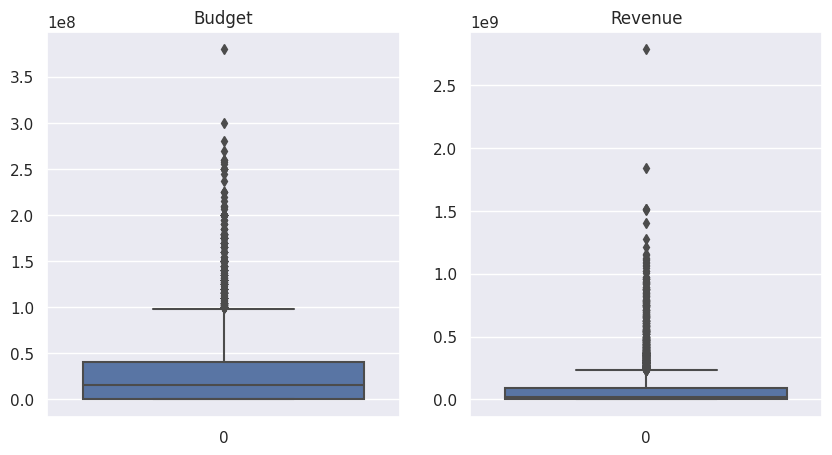

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(data=df_movies['budget'], ax=axs[0]).set(title='Budget')
sns.boxplot(data=df_movies['revenue'], ax=axs[1]).set(title='Revenue')

In [ ]:
len(df_movies[np.abs(zscore(df_movies['budget']))>3]) # outliers in budget

103

In [ ]:
len(df_movies[np.abs(zscore(df_movies['revenue']))>3]) # outliers in revenue

118

**Conclusion:**

1) We can see zero values as a minimum values of all fields. It looks wired, for example, a movie without budget. But the dataset description says: "For example, in the IMDb version it was necessary to treat values of zero in the budget field as missing. Similar findings would be very helpful to your fellow Kagglers! (It's probably a good idea to keep treating zeros as missing, with the caveat that missing budgets much more likely to have been from small budget films in the first place)". So, in most cases zero values are missing values and maybe we'll be able to drop these samples.

2) There are quite a lot of outliers in Budget and Revenue

### 2.1.3. Categorical, datetime, text and JSON fields

**Categorical variables**

In [ ]:
cat_vars = ['original_language', 'status']
for var in cat_vars:
  print(var, df_movies[var].value_counts(), sep='\n', end='\n\n')

original_language
en    4505
fr      70
es      32
zh      27
de      27
hi      19
ja      16
it      14
cn      12
ru      11
ko      11
pt       9
da       7
sv       5
nl       4
fa       4
th       3
he       3
ta       2
cs       2
ro       2
id       2
ar       2
vi       1
sl       1
ps       1
no       1
ky       1
hu       1
pl       1
af       1
nb       1
tr       1
is       1
xx       1
te       1
el       1
Name: original_language, dtype: int64

status
Released           4795
Rumored               5
Post Production       3
Name: status, dtype: int64



**Conclusion:** Most of the movies have status "Released" and released in English

**Datetime variable**

In [ ]:
# Cast 'release_date' column to datetime format
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'])

In [ ]:
# Make a new series containing release years and get min and max year
ser_years = df_movies['release_date'].dt.year.astype('Int64')
ser_years.agg(['min', 'max'])

min    1916
max    2017
Name: release_date, dtype: int64

In [ ]:
# Make another series containing lists of genres by every movie
ser_genres = df_movies['genres'].apply(lambda x: [genre['name'] for genre in json.loads(x)])
# Make an auxiliary dataframe
df_year_genres = pd.DataFrame(data={'year': ser_years, 'genres': ser_genres})
df_year_genres.head()

,year,genres
0,2009,"[Action, Adventure, Fantasy, Science Fiction]"
1,2007,"[Adventure, Fantasy, Action]"
2,2015,"[Action, Adventure, Crime]"
3,2012,"[Action, Crime, Drama, Thriller]"
4,2012,"[Action, Adventure, Science Fiction]"


In [ ]:
# Make a dictionary containing counts of movie genres by years of the following form:
#  {'Drama': {1916: 1, 1917: 1, ...}, 'Comedy': {}}

years_genres_count = defaultdict(dict)
for movie in df_year_genres.iterrows():
  for genre in movie[1]['genres']:
    years_genres_count[genre][movie[1]['year']] = years_genres_count[genre].get(movie[1]['year'], 0) + 1

In [ ]:
years_genres_count['Drama'][1916]

1

In [ ]:
# Make another auxiliary dataframe
df_years_genres = pd.DataFrame(data=years_genres_count, dtype='Int64').fillna(value=0).sort_index()
df_years_genres.head()

,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign,TV Movie
1916,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1925,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1927,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1929,0,0,0,0,0,2,1,0,0,0,0,2,0,0,0,0,1,0,0,0
1930,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Get the 5 top counts genres ...
genres_list = list(map(lambda x: x[0], genres_count))[:5]

<Axes: >

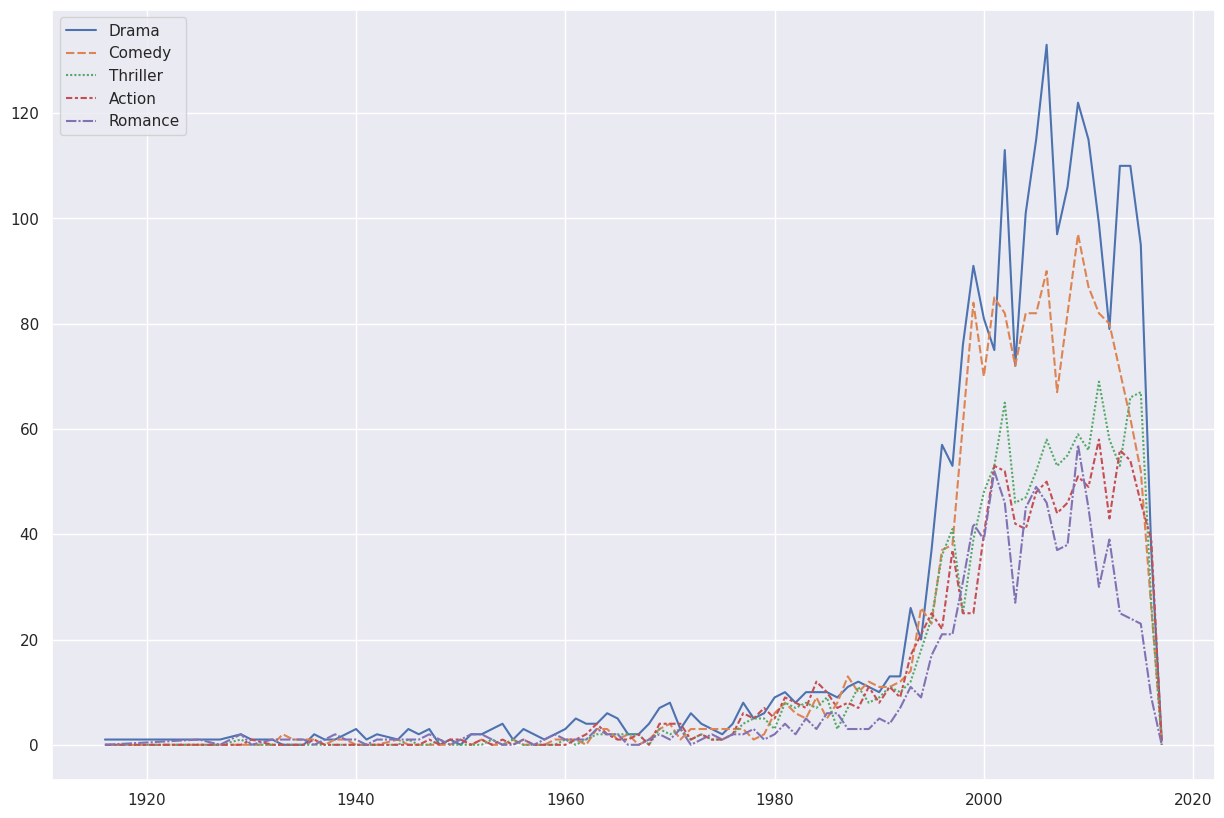

In [ ]:
# ... and plot them
_, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.lineplot(data=df_years_genres[genres_list], ax = ax)

**Conclusion:**

1) Min year in dataset is 1916, max year is 2017

2) Drama and Comedy were the most popular genres (from the perspective of the number of movies) almost every year then follow Thriller and Action

**JSON fields**

In [ ]:
# There are following fields in JSON format in the dataset
json_vars = ['keywords', 'production_companies', 'production_countries', 'spoken_languages']
# Let's take a look at them

In [ ]:
# There are 5017 different production companies in the dataset
production_companies = get_numbers_of_unique_values(df_movies['production_companies'], 'name')
len(production_companies)

5017

In [ ]:
# Top 10 most productive (from the perspective of the number of movies) companies are ...
production_companies[:10]

[('Warner Bros.', 319),
 ('Universal Pictures', 311),
 ('Paramount Pictures', 285),
 ('Twentieth Century Fox Film Corporation', 222),
 ('Columbia Pictures', 201),
 ('New Line Cinema', 165),
 ('Metro-Goldwyn-Mayer (MGM)', 122),
 ('Touchstone Pictures', 118),
 ('Walt Disney Pictures', 114),
 ('Relativity Media', 102)]

In [ ]:
# There are 88 different production countries in the dataset
production_countries = get_numbers_of_unique_values(df_movies['production_countries'], 'name')
len(production_countries)

88

In [ ]:
# Top 10 most productive (from the perspective of the number of movies) contries are ...
production_countries[:10]

[('United States of America', 3956),
 ('United Kingdom', 636),
 ('Germany', 324),
 ('France', 306),
 ('Canada', 261),
 ('Australia', 110),
 ('Italy', 72),
 ('Spain', 71),
 ('China', 59),
 ('Japan', 58)]

In [ ]:
# There are 62 different languages spoken in movies in the dataset
spoken_languages = get_numbers_of_unique_values(df_movies['spoken_languages'], 'name')
len(spoken_languages)

62

In [ ]:
# Top 10 languages are ...
spoken_languages[:10]

[('English', 4485),
 ('Français', 437),
 ('Español', 351),
 ('Deutsch', 262),
 ('Italiano', 188),
 ('Pусский', 185),
 ('普通话', 107),
 ('日本語', 97),
 ('Português', 68),
 ('العربية', 67)]

In [ ]:
# The last field in JSON format is keywords. There are 9813 different keywords/phrases in the dataset
keywords = get_numbers_of_unique_values(df_movies['keywords'], 'name')
len(keywords)

9813

In [ ]:
# Top 10 most popular keywords or pharses are ...
keywords[:10]

[('woman director', 324),
 ('independent film', 318),
 ('duringcreditsstinger', 307),
 ('based on novel', 197),
 ('murder', 189),
 ('aftercreditsstinger', 170),
 ('violence', 150),
 ('dystopia', 139),
 ('sport', 126),
 ('revenge', 118)]

In [ ]:
# It's worth noting that the most popular keyword is "woman director".
# Maybe creators think that it should attract people :)

In [ ]:
# Let's look at the basic statistics of the number of keywords by movies
df_movies['keywords'].apply(lambda x: len(json.loads(x))).describe()

count    4803.000000
mean        7.535707
std         6.280189
min         0.000000
25%         3.000000
50%         6.000000
75%        11.000000
max        97.000000
Name: keywords, dtype: float64

**Conclusion:** At first sight, it seems that JSON fields are not very useful for classification problem but maybe keywords. We can try to use them later.  


**Text fields**

In [ ]:
#  There are the following text fields in the dataset. Let's take a look at each of them
text_vars = ['original_title', 'overview', 'tagline', 'title']

In [ ]:
# There are two similar fields in the dataset - original_title and title. Both of them mean movie titles
df_movies['original_title'].head(10)

0                                      Avatar
1    Pirates of the Caribbean: At World's End
2                                     Spectre
3                       The Dark Knight Rises
4                                 John Carter
5                                Spider-Man 3
6                                     Tangled
7                     Avengers: Age of Ultron
8      Harry Potter and the Half-Blood Prince
9          Batman v Superman: Dawn of Justice
Name: original_title, dtype: object

In [ ]:
df_movies['title'].head(10)

0                                      Avatar
1    Pirates of the Caribbean: At World's End
2                                     Spectre
3                       The Dark Knight Rises
4                                 John Carter
5                                Spider-Man 3
6                                     Tangled
7                     Avengers: Age of Ultron
8      Harry Potter and the Half-Blood Prince
9          Batman v Superman: Dawn of Justice
Name: title, dtype: object

In [ ]:
# If we take a look at the differences we can see that original_title is the title in the original language and
# 'title' is the movie title translated into English
df_movies[df_movies['title'] != df_movies['original_title']][['title', 'original_title']]

,title,original_title
97,Shin Godzilla,シン・ゴジラ
215,Fantastic 4: Rise of the Silver Surfer,4: Rise of the Silver Surfer
235,Asterix at the Olympic Games,Astérix aux Jeux Olympiques
317,The Flowers of War,金陵十三釵
474,Evolution,Évolution
...,...,...
4699,The World Is Mine,Lumea e a mea
4719,The Married Woman,Une femme mariée: Suite de fragments d'un film...
4751,Gabriela,"Gabriela, Cravo e Canela"
4790,The Circle,دایره


In [ ]:
#  Take a look at tagline field and also look at tagline corresponding to ...
df_movies['tagline'].head()

0                       Enter the World of Pandora.
1    At the end of the world, the adventure begins.
2                             A Plan No One Escapes
3                                   The Legend Ends
4              Lost in our world, found in another.
Name: tagline, dtype: object

In [ ]:
ser_genres.head()

0    [Action, Adventure, Fantasy, Science Fiction]
1                     [Adventure, Fantasy, Action]
2                       [Action, Adventure, Crime]
3                 [Action, Crime, Drama, Thriller]
4             [Action, Adventure, Science Fiction]
Name: genres, dtype: object

In [ ]:
# ... the Drama movies, ...
df_movies[list(map(lambda x: 'Drama' in x, ser_genres))]['tagline']

3                                         The Legend Ends
24                        The eighth wonder of the world.
25              Nothing on Earth could come between them.
45                                       Remember Philly!
49      Reserving judgments is a matter of infinite ho...
                              ...                        
4790                                                  NaN
4793                Two gangs. One secret. One crossroad.
4795              Sometimes you've got to break the rules
4796                   What happens if it actually works?
4800                                                  NaN
Name: tagline, Length: 2297, dtype: object

In [ ]:
# ... the Comedy movie, ...
df_movies[list(map(lambda x: 'Comedy' in x, ser_genres))]['tagline']

18                              They are back... in time.
40                                               Ka-ciao!
42                               No toy gets left behind.
55                                      Change your fate.
58                                        The Rush Is On!
                              ...                        
4786                                                  NaN
4788                           An exercise in poor taste.
4794                                                  NaN
4799    A newlywed couple's honeymoon is upended by th...
4800                                                  NaN
Name: tagline, Length: 1722, dtype: object

In [ ]:
#  ... and both
df_movies[list(map(lambda x: 'Comedy' in x and 'Drama' in x, ser_genres))]['tagline']

77           Meet the little voices inside your head.
103                        It's The Coolest Job Ever.
167              Dirk Pitt. Adventure has a new name.
226                        How do you know it's love?
248                                   Smart and sexy.
                            ...                      
4772      You're only as good as the people you know.
4775                                              NaN
4776    Are all men bastards...or just misunderstood?
4784                                              NaN
4800                                              NaN
Name: tagline, Length: 576, dtype: object

In [ ]:
# In the end let's look at the overview fileds for Drama and Comedy movies

In [ ]:
df_movies[list(map(lambda x: 'Drama' in x, ser_genres))]['overview'].reset_index(drop=True)[0]

"Following the death of District Attorney Harvey Dent, Batman assumes responsibility for Dent's crimes to protect the late attorney's reputation and is subsequently hunted by the Gotham City Police Department. Eight years later, Batman encounters the mysterious Selina Kyle and the villainous Bane, a new terrorist leader who overwhelms Gotham's finest. The Dark Knight resurfaces to protect a city that has branded him an enemy."

In [ ]:
df_movies[list(map(lambda x: 'Comedy' in x, ser_genres))]['overview'].reset_index(drop=True)[0]

"Agents J (Will Smith) and K (Tommy Lee Jones) are back...in time. J has seen some inexplicable things in his 15 years with the Men in Black, but nothing, not even aliens, perplexes him as much as his wry, reticent partner. But when K's life and the fate of the planet are put at stake, Agent J will have to travel back in time to put things right. J discovers that there are secrets to the universe that K never told him - secrets that will reveal themselves as he teams up with the young Agent K (Josh Brolin) to save his partner, the agency, and the future of humankind."

In [ ]:
# Calculate number of words in 'overviews'
cow = df_movies['overview'].astype('U').apply(lambda x: len(x.split()))
cow.head()

0    28
1    34
2    41
3    65
4    55
Name: overview, dtype: int64

In [ ]:
# The main statistics of 'overview' lengths.
cow.describe()

count    4803.000000
mean       52.125338
std        27.887621
min         0.000000
25%        30.000000
50%        48.000000
75%        67.000000
max       175.000000
Name: overview, dtype: float64

**Conclusion:** For the purposes of the classification problem we can use either the 'overview' field or the 'keyword' field.

## 2.2. Bivariant analysis

Plan:


1.   Dependencies of the numerical variables between each other
2.   Dependencies of the numerical variables and genres
3.   Dependence of keywords and genres
4.   Dependence of overviews and genres



### 2.2.1. Dependencies of the numerical variables between each other

In [ ]:
# There is the following numerical variables in the Dataset
num_vars = ['budget',	'popularity',	'revenue',	'runtime',	'vote_average',	'vote_count']

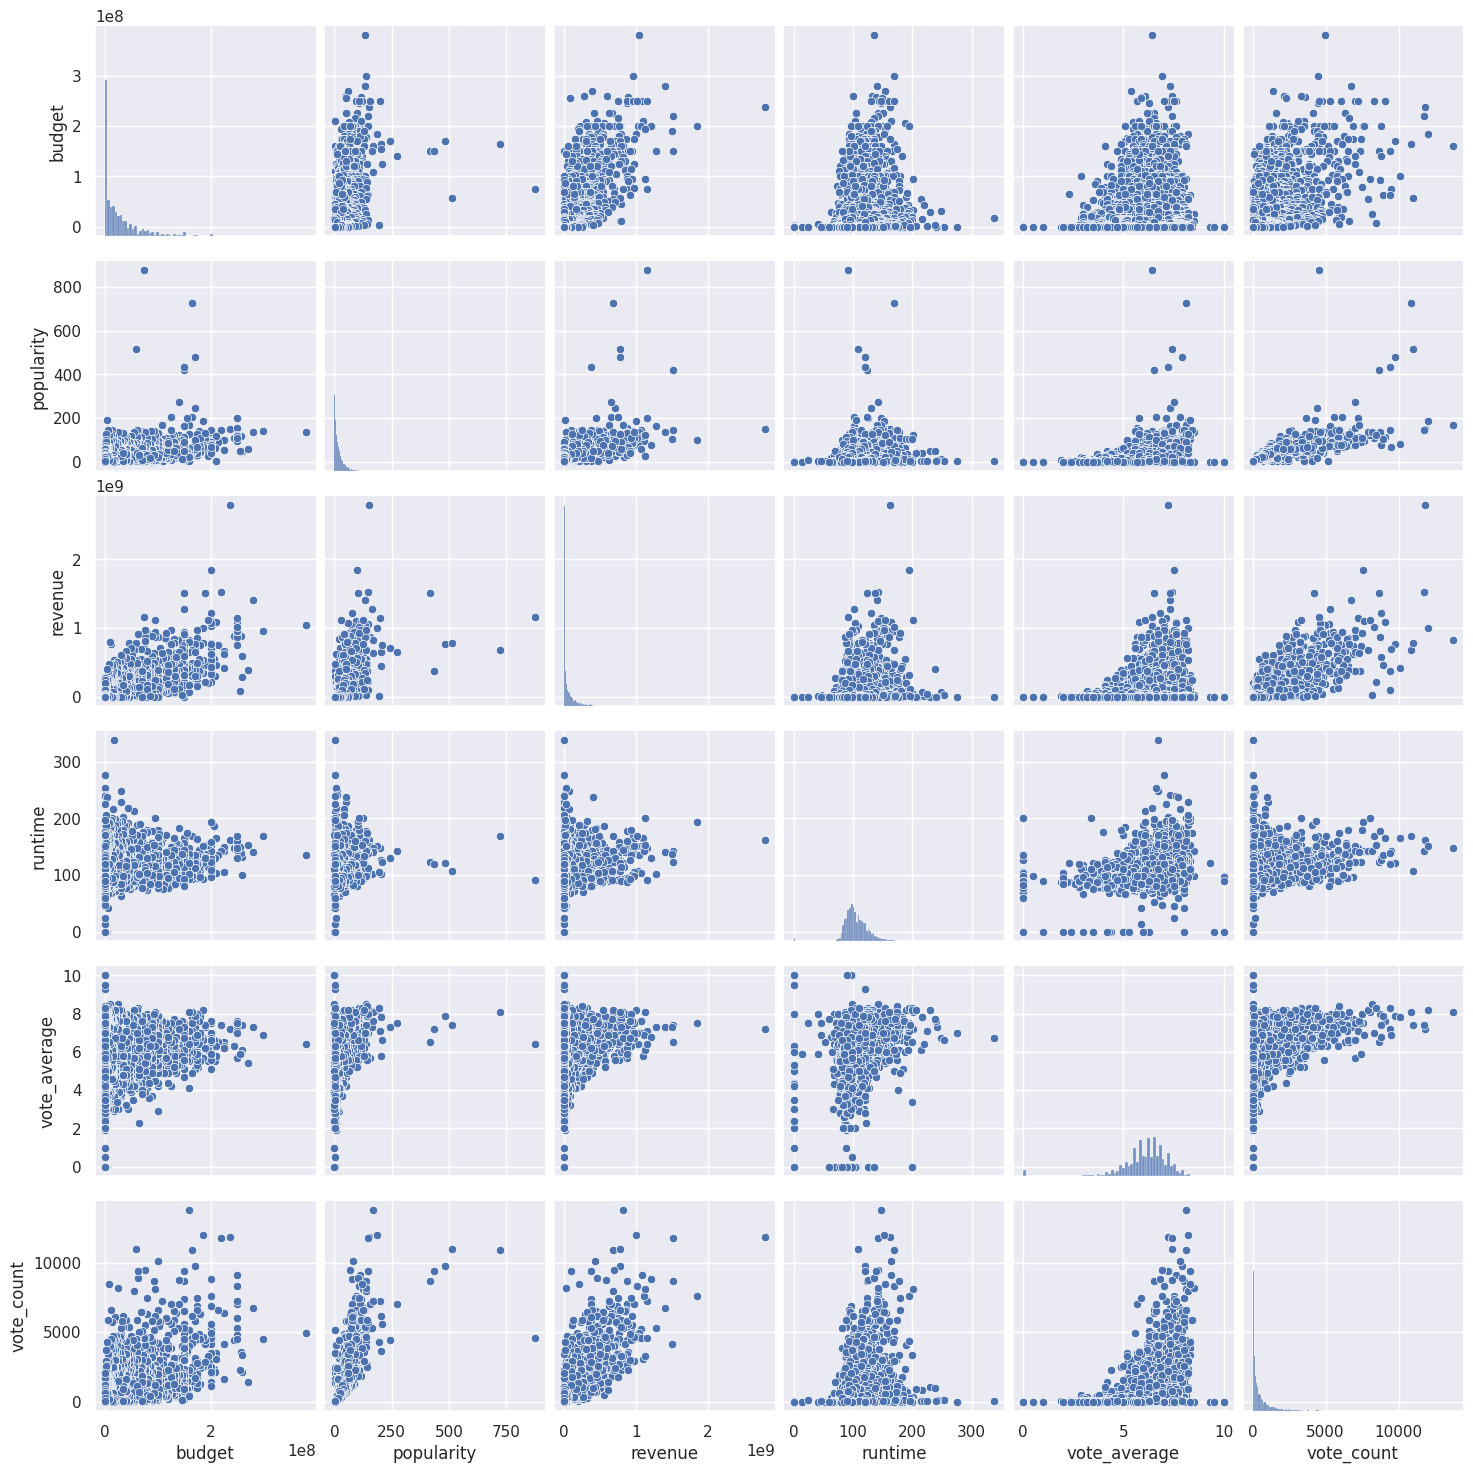

In [ ]:
# Let's take a look at their pair correlations
sns.pairplot(data=df_movies[num_vars])

**Conclusion:**
- *budget - popularity*: it can be said that movies with bigger budget will be able to be slightly more popularly than ones with the lower budget

- *budget - revenue*: there is a little linear dependence

- *budget - runtime*: no linear dependence. Big-budget movies tend to be more longer than the lower-budget ones.

- *budget - vote_average*: no linear dependence. Big-budget movies tend to be rated higher than the lower-budget ones.

- *budget - vote_count*: no linear dependence.

- *runtime - vote_average* - Longer movies are more likely to get a higher mark.

- *vote_average - revenue* The movies that received a higher rating are more likely to generate higher revenue

and so on....

### 2.2.2. Dependencies of the numerical variables and genres

In [ ]:
# Make a new dataframe contains the numerical variables and
# the genres column (with list of genres) - df_genres_num_val

In [ ]:
ser_genres.head()

0    [Action, Adventure, Fantasy, Science Fiction]
1                     [Adventure, Fantasy, Action]
2                       [Action, Adventure, Crime]
3                 [Action, Crime, Drama, Thriller]
4             [Action, Adventure, Science Fiction]
Name: genres, dtype: object

In [ ]:
genres_count[:5]

[('Drama', 2297),
 ('Comedy', 1722),
 ('Thriller', 1274),
 ('Action', 1154),
 ('Romance', 894)]

In [ ]:
df_movies['genres_lst'] = ser_genres

In [ ]:
df_genres_num_val = df_movies[num_vars + ['genres_lst']]
df_genres_num_val.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,genres_lst
0,237000000,150.437577,2787965087,162.0,7.2,11800,"[Action, Adventure, Fantasy, Science Fiction]"
1,300000000,139.082615,961000000,169.0,6.9,4500,"[Adventure, Fantasy, Action]"
2,245000000,107.376788,880674609,148.0,6.3,4466,"[Action, Adventure, Crime]"
3,250000000,112.312950,1084939099,165.0,7.6,9106,"[Action, Crime, Drama, Thriller]"
4,260000000,43.926995,284139100,132.0,6.1,2124,"[Action, Adventure, Science Fiction]"


In [ ]:
# Now, let's take a look at average values of numerical values with respect genres.
# For this purpose make a dictionary of the following view:
# {
#   'Drama': {'budget': average budget, 'popularity': average popularity, ...},
#   'Comedy': {...}, ....
# }

In [ ]:
df_genres_num_val = df_genres_num_val.fillna(0)
genres_average_num_var = defaultdict(dict)
for movie in df_genres_num_val.iterrows():
  for genre in movie[1]['genres_lst']:
    for num_var in num_vars:
      genres_average_num_var[genre][num_var] = genres_average_num_var[genre].get(num_var, 0) + movie[1][num_var]

In [ ]:
genres_average_num_var['Drama']

{'budget': 47498112157,
 'popularity': 40805.86819500007,
 'revenue': 119710983984,
 'runtime': 260171.0,
 'vote_average': 14674.599999999957,
 'vote_count': 1222649}

In [ ]:
for k, v in genres_average_num_var.items():
  total_movies_of_genre = list(filter(lambda x: x[0]==k, genres_count))[0][1]
  for var, val in v.items():
    genres_average_num_var[k][var] = val/total_movies_of_genre

In [ ]:
genres_average_num_var['Drama']

{'budget': 20678324.839791033,
 'popularity': 17.76485337178932,
 'revenue': 52116231.59947758,
 'runtime': 113.26556377884197,
 'vote_average': 6.38859381802349,
 'vote_count': 532.280801044841}

In [ ]:
# Transform the dictionary to a new Dataframe
df_genres_avg_num_vars = pd.DataFrame(data=genres_average_num_var).transpose().reset_index(names='genres')
df_genres_avg_num_vars.head()

,genres,budget,popularity,revenue,runtime,vote_average,vote_count
0,Action,5.151075e+07,30.940382,1.412131e+08,110.544194,5.989515,1135.814558
1,Adventure,6.632686e+07,39.268042,2.086602e+08,111.332911,6.156962,1430.669620
2,Fantasy,6.356061e+07,36.387043,1.933542e+08,107.278302,6.096698,1323.983491
3,Science Fiction,5.186555e+07,36.451806,1.524565e+08,107.478505,6.005607,1425.585047
4,Crime,2.784981e+07,22.853274,6.615066e+07,109.666667,6.274138,752.599138


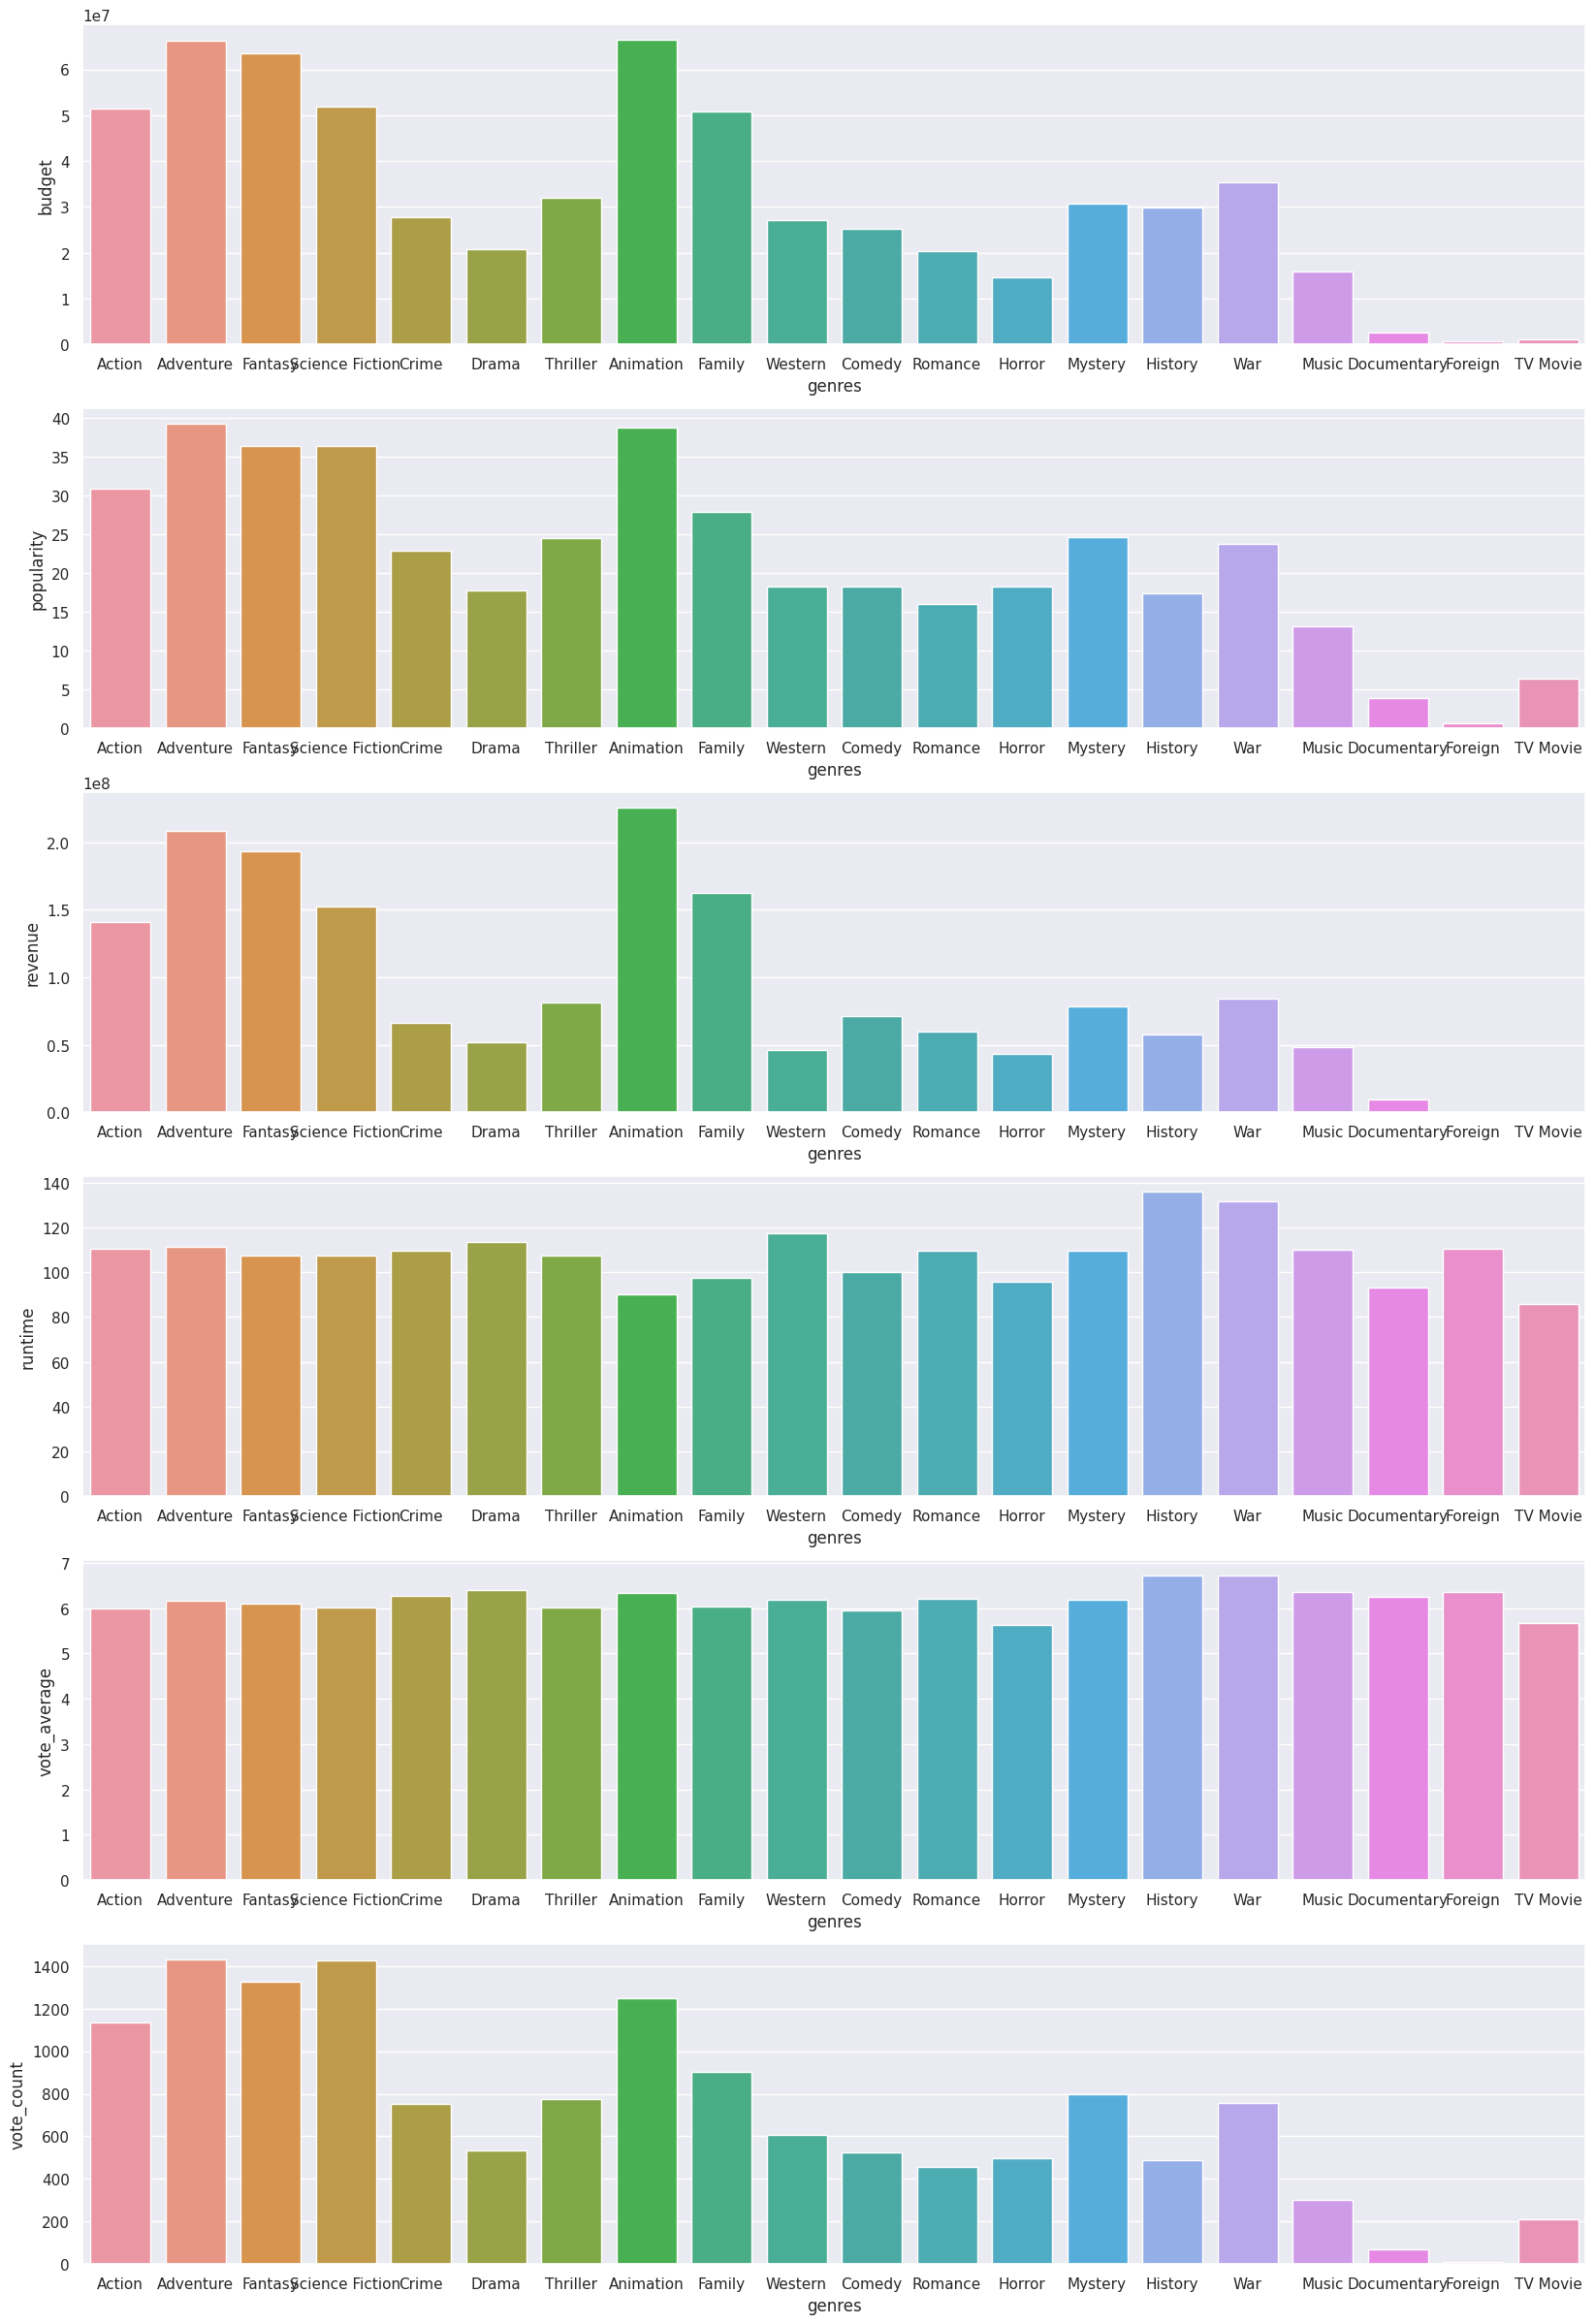

In [ ]:
# And draw a plots
f, ax = plt.subplots(len(num_vars), 1, figsize=(20, 30))
for i, var in enumerate(num_vars):
  sns.barplot(data=df_genres_avg_num_vars, x='genres', y=var, ax=ax[i])

**Conclusion:** We can see:

1. The most expensive movies are adventures, animations and fantasies
2. The most popular movies are adventures, animations
3. Anumations generate the biggest revenue
4. Historical movies are the longest movies

### 2.2.3. Dependence of keywords and genres

In [ ]:
# Make an auxiliry dataframe contains lists of keywords and genres
df_auxiliry = df_movies[ser_genres.apply(len) == 1][['keywords', 'genres_lst']]
df_auxiliry.head()

,keywords,genres_lst
44,"[{""id"": 830, ""name"": ""car race""}, {""id"": 3428,...",[Action]
64,"[{""id"": 1852, ""name"": ""mutant""}, {""id"": 4769, ...",[Science Fiction]
105,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",[Fantasy]
132,"[{""id"": 1449, ""name"": ""underworld""}, {""id"": 20...",[Adventure]
155,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",[Comedy]


In [ ]:
df_auxiliry['keywords'] = df_auxiliry['keywords'].apply(lambda x: [word['name'] for word in json.loads(x)])
df_auxiliry['genres'] = df_auxiliry['genres_lst'].apply(lambda x: x[0])
df_auxiliry.drop(columns=['genres_lst'], inplace=True)
df_auxiliry.reset_index(drop=True, inplace=True)

In [ ]:
df_auxiliry.head()

,keywords,genres
0,"[car race, speed, revenge, suspense, car, race...",Action
1,"[mutant, supernatural powers, marvel comic, su...",Science Fiction
2,"[based on novel, clock, queen, sequel, alice i...",Fantasy
3,"[underworld, hades, mythology, greek mythology...",Adventure
4,"[based on novel, desperation, robber, hold-up ...",Comedy


In [ ]:
lambda_append = lambda x: functools.reduce(lambda x1, y1: x1 + y1, x)
df_genres_keywords = df_auxiliry.groupby('genres')['keywords'].apply(lambda_append).reset_index()
df_genres_keywords

,genres,keywords
0,Action,"[car race, speed, revenge, suspense, car, race..."
1,Adventure,"[underworld, hades, mythology, greek mythology..."
2,Animation,"[based on comic strip, family, 3d, charlie bro..."
3,Comedy,"[based on novel, desperation, robber, hold-up ..."
4,Crime,[]
5,Documentary,"[ocean, lake, bird, horse, parrot, owl, ornith..."
6,Drama,"[missionary, world war ii, ranch, australia, b..."
7,Family,[]
8,Fantasy,"[based on novel, clock, queen, sequel, alice i..."
9,History,"[mongolia, genghis khan]"


In [ ]:
#  Let's look at top 3 the most popular words by genres
for row in df_genres_keywords.iterrows():
  print(f"{row[1]['genres']}: {Counter(row[1]['keywords']).most_common(3)}")

Action: [('cia', 3), ('aftercreditsstinger', 2), ('corruption', 2)]
Adventure: [('underworld', 1), ('hades', 1), ('mythology', 1)]
Animation: [('based on comic strip', 1), ('family', 1), ('3d', 1)]
Comedy: [('duringcreditsstinger', 43), ('independent film', 25), ('aftercreditsstinger', 24)]
Crime: []
Documentary: [('woman director', 12), ('independent film', 8), ('sport', 5)]
Drama: [('independent film', 53), ('woman director', 48), ('biography', 31)]
Family: []
Fantasy: [('magic', 2), ('based on novel', 1), ('clock', 1)]
History: [('mongolia', 1), ('genghis khan', 1)]
Horror: [('gore', 9), ('slasher', 8), ('murder', 8)]
Music: [('woman director', 2), ('dancing master', 1), ('dance', 1)]
Romance: [('based on novel', 1), ('small town', 1), ('widower', 1)]
Science Fiction: [('alien', 4), ('dystopia', 3), ('mutant', 2)]
Thriller: [('woman director', 4), ('blackmail', 3), ('violence', 3)]
War: [('winter', 1), ('sniper', 1), ('world war ii', 1)]
Western: [('gunslinger', 3), ('outlaw', 3), (

**Conclusion:** Interestingly:

1. The most popular fantasy movie keyword is magic.
2. The most popular science fiction movie keyword is alien.
3. The most popular horror movie keyword is gore.

and so on.

### 2.2.4. Dependence of overviews and genres

In [ ]:
def tokenize(text):
  '''
    simple tokenizer using wordpunct_tokenize from NLTK and removing punctuation and stopwords
  '''
  text_lower = text.lower()
  punct_stopwords_lst = list(punctuation) + stopwords.words('english') + ['must']
  return [word for word in wordpunct_tokenize(text_lower) if word not in punct_stopwords_lst]

In [ ]:
# Apply the above tokenizer to overview column
df_movies['overview'] = df_movies['overview'].astype('U')
df_genres_overviews = pd.DataFrame(data={'genres_lst': df_movies['genres_lst'],
                                         'tokens': df_movies['overview'].apply(lambda x: tokenize(x))})

In [ ]:
df_genres_overviews.head()

,genres_lst,tokens
0,"[Action, Adventure, Fantasy, Science Fiction]","[22nd, century, paraplegic, marine, dispatched..."
1,"[Adventure, Fantasy, Action]","[captain, barbossa, long, believed, dead, come..."
2,"[Action, Adventure, Crime]","[cryptic, message, bond, ’, past, sends, trail..."
3,"[Action, Crime, Drama, Thriller]","[following, death, district, attorney, harvey,..."
4,"[Action, Adventure, Science Fiction]","[john, carter, war, weary, former, military, c..."


In [ ]:
# Count the most frequent words using in overviews by genres.
# We'll use movies that correspond to only one genre
genres_tokens_dict = defaultdict(list)
for row in df_genres_overviews[df_genres_overviews['genres_lst'].apply(len) == 1].iterrows():
  for genre in row[1]['genres_lst']:
    genres_tokens_dict[genre] += row[1]['tokens']

for genre, tokens in genres_tokens_dict.items():
  genres_tokens_dict[genre] = nltk.FreqDist(tokens)
  print(f"{genre}: {genres_tokens_dict[genre].most_common(10)}")

Action: [('agent', 7), ('bly', 5), ('terry', 5), ('brother', 4), ('gang', 4), ('stevens', 4), ('military', 3), ('race', 3), ('former', 3), ('star', 3)]
Science Fiction: [('earth', 7), ('world', 5), ('man', 3), ('years', 3), ('old', 3), ('planet', 3), ('aliens', 3), ('one', 3), ('survivors', 3), ('woman', 3)]
Fantasy: [('king', 4), ('dragon', 3), ('alice', 2), ('time', 2), ('bowen', 2), ('face', 2), ('heart', 2), ('draco', 2), ('order', 2), ('save', 2)]
Adventure: [('year', 4), ('old', 3), ('father', 3), ('ship', 3), ('two', 3), ('robin', 3), ('research', 3), ('stolen', 3), ('son', 2), ('zeus', 2)]
Comedy: [('one', 54), ('life', 41), ('two', 34), ('friends', 34), ('get', 31), ('new', 31), ('school', 31), ('find', 28), ('make', 28), ('high', 26)]
Drama: [('life', 103), ('family', 76), ('young', 73), ('story', 69), ('new', 58), ('father', 56), ('man', 49), ('one', 43), ('world', 42), ('son', 42)]
Animation: [('home', 2), ('family', 2), ('snoopy', 1), ('embarks', 1), ('upon', 1), ('greates

**Conclusion:** Unfortunately, there are no visible patterns of words from overviews that could help us to determine movie genre.

# 3. Data cleaning

Before we'll perform data cleaning let's make a few assumptions:
1) We're goint to use only 'overview' text to classify movies by genres
2) We're going to solve a binary classification problem. Therefore, we'll leave only two genres - Drama and Comedy
3) we're going to consider only movies that correspond to only one genre (Drama or Comedy)

In [ ]:
genres = ['Drama', 'Comedy']

In [ ]:
# lambda functions that returns True if movie corresponds to only one genre (len(x)==1)
# and the only genre is Drama or Comedy (x[0] in genres)
lambda_drams_or_comedy = lambda x: len(x)==1 and x[0] in genres
df = df_movies[df_movies['genres_lst'].apply(lambda_drams_or_comedy)][['overview', 'genres_lst']]\
  .dropna()\
  .reset_index(drop=True)
df['genre'] = df['genres_lst'].apply(lambda x: x[0])
df.drop(columns='genres_lst', inplace=True)

In [ ]:
df.head()

,overview,genre
0,After Dick Harper loses his job at Globodyne i...,Comedy
1,"Set in northern Australia before World War II,...",Drama
2,"In October 1991, a confluence of weather condi...",Drama
3,A biopic depicting the life of filmmaker and a...,Drama
4,Travel writer Lemuel Gulliver takes an assignm...,Comedy


In [ ]:
#  As we intend to get rid of stopwords, let's choose the appropriate list.
#  There are stopwords in sklearn and in NLTK

In [ ]:
print("The number of stopwords from sklearn:", len(ENGLISH_STOP_WORDS))
print("The number of stopwords from NLTK:", len(stopwords.words('english')))

The number of stopwords from sklearn: 318
The number of stopwords from NLTK: 179


In [ ]:
# Take a look at the difference these lists
list(set(ENGLISH_STOP_WORDS) - set(stopwords.words('english')))[:20]

['alone',
 'put',
 'namely',
 'see',
 'two',
 'yet',
 'even',
 'formerly',
 'never',
 'anything',
 'thus',
 'former',
 'indeed',
 'found',
 'along',
 'ten',
 'co',
 'move',
 'within',
 'every']

**Conclusion:** Stopwords from sklearn (ENGLISH_STOP_WORDS) looks a bit too much - these words can influence on classification. We'll use stopwords from NLTK

In [ ]:
def transform(text: str, stopwords: list = None) -> str:
  '''
  Function for data cleaning
  1) Convert to lowercase
  2) Replace all symbols except alphabet, numbers and spaces with " "
  3) Replace all numbers with symbol "X"
  4) Remove stopwords
  '''
  output = re.sub(r"[^a-zA-z0-9\s]", " ", text.lower())
  output = re.sub(r"\d", "X", output)
  if stopwords:
    output = [word for word in output.split() if word not in stopwords]
    output = " ".join(output)
  return output

In [ ]:
# Make Dataframe with the two additional columns - transformed overview with stopwords and without stopwords
df['overview_w_stopwords'] = df['overview'].apply(transform)
df['overview_wo_stopwords'] = df['overview'].apply(transform, stopwords=stopwords.words('english'))
df.drop(columns='overview', inplace=True)
df.head()

,genre,overview_w_stopwords,overview_wo_stopwords
0,Comedy,after dick harper loses his job at globodyne i...,dick harper loses job globodyne enron esque co...
1,Drama,set in northern australia before world war ii ...,set northern australia world war ii english ar...
2,Drama,in october XXXX a confluence of weather condi...,october XXXX confluence weather conditions com...
3,Drama,a biopic depicting the life of filmmaker and a...,biopic depicting life filmmaker aviation pione...
4,Comedy,travel writer lemuel gulliver takes an assignm...,travel writer lemuel gulliver takes assignment...


In [ ]:
# Let's look at the example overview WITH stopwords ...
df.iloc[3]['overview_w_stopwords']

'a biopic depicting the life of filmmaker and aviation pioneer howard hughes from XXXX to XXXX  during which time he became a successful film producer and an aviation magnate  while simultaneously growing more unstable due to severe obsessive compulsive disorder '

In [ ]:
# ... and WITHOUT stopwords
df.iloc[3]['overview_wo_stopwords']

'biopic depicting life filmmaker aviation pioneer howard hughes XXXX XXXX time became successful film producer aviation magnate simultaneously growing unstable due severe obsessive compulsive disorder'

**Conclusion:** We've made the dataframe that we're going to use in the next section

# 4. Modelling and evalution

## 4.1. Baseline

First of all, We're going to repeat the result from [Beginner's Guide to NLP 🔥| Machine Learning| 🔥](https://www.kaggle.com/code/alexanderakhterov/beginner-s-guide-to-nlp-machine-learning/edit) and use their as a baseline

In [ ]:
# By the way, it's worth noting that we deak with imbalanced dataset. Therefore, we should either
# align two classes or leverage appropriate weighted metrics. We'll pick the second option.
df['genre'].value_counts()

Drama     370
Comedy    282
Name: genre, dtype: int64

### 4.1.1. Vectorizer: TD-IDF. Alg: SVM. Dataset with stopwords

In [ ]:
X, y = df['overview_w_stopwords'], df['genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [ ]:
param_grid = {'tfidf__ngram_range': [(1,1), (1,2), (2,2), (1,3)],
              'svc__C': [0.1, 0.5, 1, 10],
              'svc__kernel': ['linear', 'poly', 'rbf'],
             }

txt_clf = Pipeline([('tfidf', TfidfVectorizer()),
                    ('svc', SVC(max_iter=10000))])

In [ ]:
#  Use weighted f1 metric as th dataset is imbalanced
search = GridSearchCV(txt_clf, param_grid, scoring='f1_weighted')
search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svc', SVC(max_iter=10000))]),
             param_grid={'svc__C': [0.1, 0.5, 1, 10],
                         'svc__kernel': ['linear', 'poly', 'rbf'],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2),
                                                (1, 3)]},
             scoring='f1_weighted')

In [ ]:
# Th best metric value
search.best_score_

0.7589383558400784

In [ ]:
# The best estimator
search.best_params_

{'svc__C': 1, 'svc__kernel': 'linear', 'tfidf__ngram_range': (1, 1)}

In [ ]:
y_pred = search.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Comedy       0.71      0.62      0.66        63
       Drama       0.68      0.76      0.72        68

    accuracy                           0.69       131
   macro avg       0.70      0.69      0.69       131
weighted avg       0.70      0.69      0.69       131



### 4.1.2. Vectorizer: TD-IDF. Alg: SVM. Dataset without stopwords

In [ ]:
X, y = df['overview_wo_stopwords'], df['genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [ ]:
search = GridSearchCV(txt_clf, param_grid, scoring='f1_weighted')
search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svc', SVC(max_iter=10000))]),
             param_grid={'svc__C': [0.1, 0.5, 1, 10],
                         'svc__kernel': ['linear', 'poly', 'rbf'],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2),
                                                (1, 3)]},
             scoring='f1_weighted')

In [ ]:
search.best_score_

0.7507168566100167

In [ ]:
search.best_params_

{'svc__C': 10, 'svc__kernel': 'linear', 'tfidf__ngram_range': (1, 2)}

In [ ]:
y_pred = search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Comedy       0.88      0.66      0.75        64
       Drama       0.73      0.91      0.81        67

    accuracy                           0.79       131
   macro avg       0.80      0.78      0.78       131
weighted avg       0.80      0.79      0.78       131



**Conclusion:** It's worth noting that:

1. using unigram works better then bigram or trigram;
2. the results are better when we use text WITH stopwords
3. *recall* on Comedy class is very low and *precision* on Comedy class is heigher. It means we predict that a Drama is a Comedy more often then a Comedy is a Drama: False Negative > False Positive (for Comedy class) and vise versa for Drama class   

## 4.2. Using words embeddings - GLOVE

([https://nlp.stanford.edu/projects/glove/](https://nlp.stanford.edu/projects/glove/))

In [197]:
# Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50dim vectors) model
model_gigaword = api.load("glove-wiki-gigaword-50")

[=============================================-----] 91.6% 60.4/66.0MB downloaded


In [205]:
embeddings_dim = model_gigaword.vector_size
print('Embeddings dimension:', embeddings_dim)

Embeddings dimension: 50


### 4.2.1. SVM on average vectors

1. For every overview:

  1.1. Calculate the average vector across all word vectors

In [206]:
def get_average_vector_from_text(text: str, UNK_str: str = 'unk'):
  '''
  Calculate average vector across all word vectors in text. If there is no such word in the
  vocabulary we use vector for unknow word.
  '''
  output = np.zeros(embeddings_dim)
  words = text.split()
  for word in words:
    output += model_gigaword.get_vector(word, norm=True) \
      if word in model_gigaword.index_to_key else model_gigaword.get_vector(UNK_str, norm=True)
  return output/len(words)

In [207]:
# Define X, y and split them on the train and test datasets
X, y = df['overview_wo_stopwords'].apply(get_average_vector_from_text).to_list(), df['genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [208]:
# Use grid search to find the best parameters
param_grid = {'C': [0.1, 0.5, 1, 10, 100],
              'kernel': ['linear', 'poly', 'rbf'],
             }
svc = SVC(max_iter=10000)

clf = GridSearchCV(svc, param_grid, scoring='f1_weighted')
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(max_iter=10000),
             param_grid={'C': [0.1, 0.5, 1, 10, 100],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='f1_weighted')

In [209]:
# The best score on the test dataset
clf.best_score_

0.7553625105790788

In [210]:
# The parameters of the best estimator
clf.best_params_

{'C': 10, 'kernel': 'rbf'}

In [211]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Comedy       0.82      0.77      0.79        60
       Drama       0.81      0.86      0.84        71

    accuracy                           0.82       131
   macro avg       0.82      0.81      0.81       131
weighted avg       0.82      0.82      0.82       131



**Conclusion:** The result is better than one we've achieved without using pre-trained word embeddings

### 4.2.2. SVM on concatenated vectors

1. Define max_overview_length

2. For every overview:

  2.1. Concatenate max_overview_length word vectors to each other

In [ ]:
# Max possible overview length.
# If overview contains more than max_overview_length words then we'll trim it
# If overview contains less than max_overview_length words then we'll pad it by zero vectors
max_overview_length = 20

In [ ]:
def get_concatenate_vector_from_text(text: str, UNK_str: str = 'unk'):
  '''
  Calculate concatenated vector over the first max_overview_length word vectors in text.
  '''
  output = np.zeros(embeddings_dim*max_overview_length)
  words = text.split()
  for i, word in enumerate(words[:max_overview_length]):
    output[i*embeddings_dim:(i+1)*embeddings_dim] = model_gigaword.get_vector(word, norm=True) \
      if word in model_gigaword.index_to_key else model_gigaword.get_vector(UNK_str, norm=True)
  return output

In [ ]:
X, y = df['overview_wo_stopwords'].apply(get_concatenate_vector_from_text).to_list(), df['genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [ ]:
param_grid = {'C': [0.1, 0.5, 1, 10, 100],
              'kernel': ['linear', 'poly', 'rbf'],
             }
svc = SVC(max_iter=10000)

clf = GridSearchCV(svc, param_grid, scoring='f1_weighted')
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(max_iter=10000),
             param_grid={'C': [0.1, 0.5, 1, 10, 100],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='f1_weighted')

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Comedy       0.90      0.35      0.50        55
       Drama       0.67      0.97      0.80        76

    accuracy                           0.71       131
   macro avg       0.79      0.66      0.65       131
weighted avg       0.77      0.71      0.67       131



**Conclusion:** The result using average vectors is much better

### 4.2.3. Long short-term memory (LSTM)

In [ ]:
df['overview_wo_stopwords'].apply(lambda x: len(x.split())).mean()

29.368098159509202

In [ ]:
max_overview_length = 50

In [ ]:
def get_list_of_embeddings_from_text(text: str, UNK_str: str = 'unk'):
  '''
  Form list of word vectors
  '''
  output = np.zeros((max_overview_length, embeddings_dim))
  words = text.split()
  for i, word in enumerate(words[:max_overview_length]):
    word_embedding = model_gigaword.get_vector(word, norm=True) \
      if word in model_gigaword.index_to_key else model_gigaword.get_vector(UNK_str, norm=True)
    output[i] = word_embedding
  return output

In [ ]:
# Apply the function above to the overview_wo_stopwords column
X = np.array(df['overview_wo_stopwords'].apply(get_list_of_embeddings_from_text).to_list())
# Transform target column to 1 and 0 values
y = np.array(df['genre'].apply(lambda x: 1 if x=='Drama' else 0).to_list())
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [ ]:
X.shape, y.shape

((652, 50, 50), (652,))

In [ ]:
def ClassificationLSTMModel(input_shape):
    inputs = Input(input_shape)
    # X = Bidirectional(LSTM(64))(inputs)
    X = LSTM(units=128)(inputs)
    # X = Dropout(rate=0.5)(X)
    X = Dense(activation='relu', units=64)(X)
    X = Dropout(rate=0.5)(X)
    X = Dense(units=1)(X)
    model = Model(inputs=inputs, outputs=X)
    return model

In [ ]:
model = ClassificationLSTMModel((max_overview_length, embeddings_dim))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50)]          0         
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 99,969
Trainable params: 99,969
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=60,
                    batch_size=32,
                    validation_data=(X_test, y_test)
                    )

Epoch 1/60
17/17 [==============================] - 7s 195ms/step - loss: 2.8409 - accuracy: 0.4299 - val_loss: 2.2264 - val_accuracy: 0.4427
Epoch 2/60
17/17 [==============================] - 1s 85ms/step - loss: 2.1784 - accuracy: 0.4299 - val_loss: 1.8512 - val_accuracy: 0.4427
Epoch 3/60
17/17 [==============================] - 1s 78ms/step - loss: 1.6853 - accuracy: 0.4319 - val_loss: 1.3666 - val_accuracy: 0.4427
Epoch 4/60
17/17 [==============================] - 1s 78ms/step - loss: 1.1616 - accuracy: 0.4549 - val_loss: 0.9946 - val_accuracy: 0.4580
Epoch 5/60
17/17 [==============================] - 1s 80ms/step - loss: 1.0183 - accuracy: 0.4626 - val_loss: 0.9071 - val_accuracy: 0.4580
Epoch 6/60
17/17 [==============================] - 1s 78ms/step - loss: 0.9721 - accuracy: 0.5144 - val_loss: 0.8442 - val_accuracy: 0.4351
Epoch 7/60
17/17 [==============================] - 1s 78ms/step - loss: 0.9104 - accuracy: 0.4894 - val_loss: 0.8486 - val_accuracy: 0.4427
Epoch 8/60
1

In [ ]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 22ms/step - loss: 1.1196 - accuracy: 0.7710


[1.1196460723876953, 0.7709923386573792]

<Axes: >

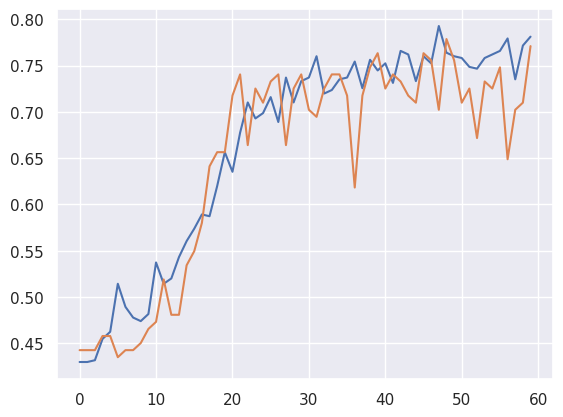

In [ ]:
_, ax = plt.subplots(1, 1)
sns.lineplot(data=history.history['accuracy'], ax=ax)
sns.lineplot(data=history.history['val_accuracy'], ax=ax)

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

5/5 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.79      0.66      0.72        58
           1       0.76      0.86      0.81        73

    accuracy                           0.77       131
   macro avg       0.78      0.76      0.76       131
weighted avg       0.77      0.77      0.77       131



**Conclusion:** It's worth noting that LSTM shows the worse results then simple SVM on average of pre-trained embeddings

## 4.3. Using sentence embeddings - SBert

(https://www.sbert.net/)

Now we'll try to use a whole sentence embeddings and then use these sentenece embeddings in the SVM and in the FCN (Fully-connected network). For this purpose we're going to leverage SentenceTransformers library.

In [ ]:
sentence_embeddings_model = SentenceTransformer('all-MiniLM-L6-v2')

### 4.3.1. SVM on sentences vectors

1. For every overview:

  1.1. Get sentence embedding

In [ ]:
X, y = sentence_embeddings_model.encode(df['overview_w_stopwords']), df['genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [ ]:
param_grid = {'C': [0.1, 0.5, 1, 10, 100],
              'kernel': ['linear', 'poly', 'rbf'],
             }
svc = SVC(max_iter=10000)

clf = GridSearchCV(svc, param_grid, scoring='f1_weighted')
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(max_iter=10000),
             param_grid={'C': [0.1, 0.5, 1, 10, 100],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='f1_weighted')

In [ ]:
clf.best_score_

0.7780591682697565

In [ ]:
clf.best_params_

{'C': 1, 'kernel': 'rbf'}

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Comedy       0.78      0.82      0.80        60
       Drama       0.84      0.80      0.82        71

    accuracy                           0.81       131
   macro avg       0.81      0.81      0.81       131
weighted avg       0.81      0.81      0.81       131



**Conclusion:** From some perspective, this result may be a bit better than the result we've achieved using pre-trained word embeddings - despite the fact that total metrics are less by 0.01 but we have approximately equal precision and recall of both classes.      

### 4.3.2. Fully-Connected network (FCN)

We'are going to use Fully-Connected Network with the following architecure:

1th Layer - Input

2th Layer - FCN with 128 units and ReLU as an activation function

3th Layer - Dropout with rate 0.5 for regularization

4th Layer - FCN with 128 units and ReLU as an activation function

5th Layer - Output with 1 unit and sigmoid as an activation function

In [ ]:
X = sentence_embeddings_model.encode(df['overview_w_stopwords'])
y = np.array(df['genre'].apply(lambda x: 1 if x=='Drama' else 0).to_list())
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [ ]:
# Embedding dimension
sent_embed_dim = len(X[0])
sent_embed_dim

384

In [ ]:
# Create a NN model using Keras functional API
def ClassificationModel(input_shape):
    inputs = Input(input_shape)
    X = Dense(activation='relu', units=128)(inputs)
    X = Dropout(rate=0.5)(X)
    X = Dense(activation='relu', units=128)(X)
    X = Dense(units=1)(X)
    model = Model(inputs=inputs, outputs=X)
    return model

In [ ]:
model = ClassificationModel((sent_embed_dim))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384)]             0         
                                                                 
 dense_2 (Dense)             (None, 128)               49280     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 65,921
Trainable params: 65,921
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=60,
                    batch_size=32,
                    validation_data=(X_test, y_test)
                    )

Epoch 1/60
17/17 [==============================] - 4s 33ms/step - loss: 3.0742 - accuracy: 0.4472 - val_loss: 1.9532 - val_accuracy: 0.3740
Epoch 2/60
17/17 [==============================] - 0s 12ms/step - loss: 1.5966 - accuracy: 0.4472 - val_loss: 1.4826 - val_accuracy: 0.3740
Epoch 3/60
17/17 [==============================] - 0s 10ms/step - loss: 1.2275 - accuracy: 0.4472 - val_loss: 1.3053 - val_accuracy: 0.3740
Epoch 4/60
17/17 [==============================] - 0s 12ms/step - loss: 1.1385 - accuracy: 0.4472 - val_loss: 1.2028 - val_accuracy: 0.3740
Epoch 5/60
17/17 [==============================] - 0s 13ms/step - loss: 1.0593 - accuracy: 0.4472 - val_loss: 1.1228 - val_accuracy: 0.3740
Epoch 6/60
17/17 [==============================] - 0s 8ms/step - loss: 0.9660 - accuracy: 0.4472 - val_loss: 1.0630 - val_accuracy: 0.3740
Epoch 7/60
17/17 [==============================] - 0s 8ms/step - loss: 0.9447 - accuracy: 0.4472 - val_loss: 1.0097 - val_accuracy: 0.3740
Epoch 8/60
17/1

In [ ]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 3ms/step - loss: 0.6215 - accuracy: 0.7481


[0.6215107440948486, 0.7480915784835815]

<Axes: >

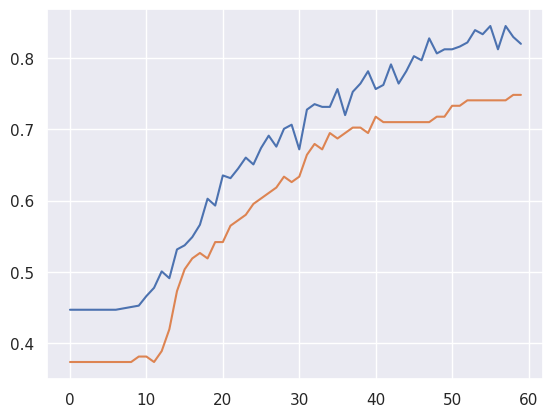

In [ ]:
_, ax = plt.subplots(1, 1)
sns.lineplot(data=history.history['accuracy'], ax=ax)
sns.lineplot(data=history.history['val_accuracy'], ax=ax)

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

5/5 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.64      0.76      0.69        49
           1       0.84      0.74      0.79        82

    accuracy                           0.75       131
   macro avg       0.74      0.75      0.74       131
weighted avg       0.76      0.75      0.75       131



**Conclusion:** As in previous time, NN has shown the worse result

## 4.4. Using OpenAI sentence embeddings + vector database (Chroma)

Now we're going to use OpenAI model for getting sentence embeddings and save them into a vector database - Chroma. After that we'are going to try classify movies by help (1) simple cosine distance (2) SVM (3) FCN  

In [237]:
_ = load_dotenv("/content/drive/MyDrive/Colab Notebooks/Data/.env") # read local .env file with api_keys from OpenAI

In [238]:
db_path = '/content/drive/MyDrive/Colab Notebooks/Data/ChromaDB_text_class' # path for ChromaDB files

In [239]:
client = chromadb.PersistentClient(path=db_path) # create ChromaDB client

In [240]:
# Create an embedding function for getting embeddings. ChromaDB libtrary has an in-bult wrapper of OpenAI API
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=os.environ['OPENAI_API_KEY'],
                organization_id=os.environ['OPENAI_ORGANIZATION'],
                model_name="text-embedding-ada-002"
            )

In [241]:
# Create two collections of documents: one for overviews with stopwords and another without stopwords
collection_w_stopwords = client.get_or_create_collection(name="overview_w_stopwords",
                                                         metadata={"hnsw:space": "cosine"},
                                                         embedding_function=openai_ef)
collection_wo_stopwords = client.get_or_create_collection(name="overview_wo_stopwords",
                                                          metadata={"hnsw:space": "cosine"},
                                                          embedding_function=openai_ef)

In [235]:
# Here we get overview embeddings from OpenAI (the dimension of such embeddings is 1536) and save them into ChromaDB. Since every request to OpenAI's model is paid
# we made them only once and then we're going to use data from ChromaDB

# collection_w_stopwords.add(
#     documents=df['overview_w_stopwords'].to_list(),
#     metadatas=[{"genre": genre} for genre in df['genre']],
#     ids=list(map(str, df.index.to_list()))
# )

# collection_wo_stopwords.add(
#     documents=df['overview_wo_stopwords'].to_list(),
#     metadatas=[{"genre": genre} for genre in df['genre']],
#     ids=list(map(str, df.index.to_list()))
# )

In [242]:
X_train, X_test, y_train, y_test = train_test_split(df['overview_wo_stopwords'], df['genre'])

### 4.4.1. Cosine distance

In [243]:
# Get overview embeddings from collection_wo_stopwords by indices of X_test dataset. It looks like list of list:
# [[x_1....x_1536], [x_1....x_1536], ....]
embds = collection_wo_stopwords.get(ids=[str(idx) for idx in X_test.index], include=["embeddings"])["embeddings"]
# Make a query to get the top 2 closest embeddings to each of the overview embeddings. We request the top 2 closest embeddings
# because the closest embedding is this embedding itself. Recall that we added to the collection all overview embeddings.
# At the end we get the value of "metadatas" key because there are genres there
y_and_y_pred = collection_wo_stopwords.query(query_embeddings=embds, n_results=2, include=["metadatas"])["metadatas"]

In [245]:
#  Let's take a look at y_and_y_pred. The first element is the true genre of the appropriate overview and
# the second element is the genre of the closest overview emebedding
y_and_y_pred[:5]

[[{'genre': 'Drama'}, {'genre': 'Comedy'}],
 [{'genre': 'Drama'}, {'genre': 'Drama'}],
 [{'genre': 'Comedy'}, {'genre': 'Comedy'}],
 [{'genre': 'Comedy'}, {'genre': 'Drama'}],
 [{'genre': 'Drama'}, {'genre': 'Drama'}]]

In [244]:
# Calculate the accuracy metric.
accuracy = 0
for y in y_and_y_pred:
  if y[0] == y[1]:
    accuracy +=1
accuracy /= len(y_and_y_pred)
print(f"accuracy = {accuracy:.2f}%")

accuracy = 0.74%


**Conclusion:** Not so bad for the simple cosine distance

### 4.4.2. SVM

In [247]:
X_train = collection_wo_stopwords.get(ids=[str(idx) for idx in X_train.index], include=["embeddings"])["embeddings"]
X_test = collection_wo_stopwords.get(ids=[str(idx) for idx in X_test.index], include=["embeddings"])["embeddings"]
y_train = y_train.to_list()
y_test = y_test.to_list()

In [249]:
param_grid = {'C': [0.1, 0.5, 1, 10, 100],
              'kernel': ['linear', 'poly', 'rbf'],
             }
svc = SVC()

clf = GridSearchCV(svc, param_grid, scoring='accuracy')
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 0.5, 1, 10, 100],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy')

In [250]:
clf.best_score_

0.5798863875447087

In [251]:
clf.best_params_

{'C': 1, 'kernel': 'poly'}

In [252]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Comedy       0.30      0.04      0.07        75
       Drama       0.53      0.92      0.67        88

    accuracy                           0.52       163
   macro avg       0.41      0.48      0.37       163
weighted avg       0.42      0.52      0.40       163



**Conclusion:** Terrible result!

### 4.4.3. FCN

In [253]:
y_train = list(map(lambda x: 1 if x=='Drama' else 0, y_train))
y_test = list(map(lambda x: 1 if x=='Drama' else 0, y_test))

In [254]:
sent_embed_dim = len(X_train[0])
sent_embed_dim

1536

In [283]:
def ClassificationModel(input_shape):
    inputs = Input(input_shape)
    X = Dense(activation='relu', units=128)(inputs)
    X = Dropout(rate=0.5)(X)
    X = Dense(activation='relu', units=64)(X)
    X = Dropout(rate=0.5)(X)
    X = Dense(units=1)(X)
    model = Model(inputs=inputs, outputs=X)
    return model

In [286]:
model = ClassificationModel((sent_embed_dim))
model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 1536)]            0         
                                                                 
 dense_42 (Dense)            (None, 128)               196736    
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_43 (Dense)            (None, 64)                8256      
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                                 
 dense_44 (Dense)            (None, 1)                 65        
                                                                 
Total params: 205,057
Trainable params: 205,057
Non-traina

In [287]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_test, y_test)
                    )

Epoch 1/100
16/16 [==============================] - 3s 134ms/step - loss: 2.7117 - accuracy: 0.4242 - val_loss: 1.3365 - val_accuracy: 0.4601
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 1.4257 - accuracy: 0.4242 - val_loss: 1.0581 - val_accuracy: 0.4601
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 1.0940 - accuracy: 0.4221 - val_loss: 0.9087 - val_accuracy: 0.4601
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.9544 - accuracy: 0.4242 - val_loss: 0.8193 - val_accuracy: 0.4601
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8809 - accuracy: 0.4365 - val_loss: 0.7583 - val_accuracy: 0.4601
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8119 - accuracy: 0.4672 - val_loss: 0.7266 - val_accuracy: 0.4601
Epoch 7/100
16/16 [==============================] - 0s 7ms/step - loss: 0.7935 - accuracy: 0.4447 - val_loss: 0.7089 - val_accuracy: 0.4601
Epoch 8/1

In [288]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 3ms/step - loss: 0.7276 - accuracy: 0.5031


[0.7275685667991638, 0.5030674934387207]

<Axes: >

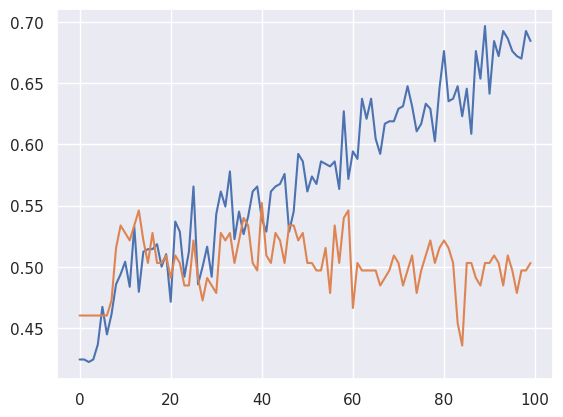

In [289]:
_, ax = plt.subplots(1, 1)
sns.lineplot(data=history.history['accuracy'], ax=ax)
sns.lineplot(data=history.history['val_accuracy'], ax=ax)

**Conclusion:** We've gotten a "perfect" overfitting :) I think we have no enough data to train

**Takeaway:** We've tried a lot of technics. We started from td-idf baseline result, then we leveraged pre-trained word embeddings and got sentence embeddings using the SentenceTransformers library and the OpenAI models. The best results have been achieved using SVM on the average vectors of the pre-trained word embeddings. Why did using NN give not good results? I think it can be because there is no strong semantic similarity between comedian overviews (and it's the truth also for overviews of dramatic movies). Yes, there are a number of common words but the overviews of comedian (or dramatic) movies are different from the semantic point of view.